In [1]:
import pandas as pd

In [2]:
from sklearn.preprocessing import normalize, minmax_scale
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, Birch
from sklearn.manifold import TSNE

In [3]:
from tslearn.clustering import TimeSeriesKMeans
import plotly.graph_objects as go
import seaborn as sns

In [4]:
%matplotlib inline

In [5]:
updated_df = updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [6]:
US_input_df = updated_df.copy()
US_input_df = US_input_df[US_input_df["location_name"] == "US"]
US_input_df = US_input_df[["date", "value"]]
US_input_df["date"] = pd.to_datetime(US_input_df["date"])
US_input_df.set_index("date", inplace = True)
US_input_df.sort_values(by = "date", inplace = True)
US_input_df["ds"] = US_input_df.index
US_input_df["unique_id"] = "series_1"
US_input_df.rename(columns = {"value": "y"}, inplace=True)

US_true_df = US_input_df.copy()

US_input_df = US_input_df.loc[:"12-15-2024"]

In [7]:
all_input_df = updated_df.copy()
all_input_df = all_input_df[["date", "value", "location_name"]]
all_input_df["date"] = pd.to_datetime(all_input_df["date"])
all_input_df.sort_values(by = ["location_name", "date"], inplace = True)
all_input_df.rename(columns = {"date": "ds", "value": "y", "location_name": "unique_id"}, inplace = True)

all_input_df = all_input_df[all_input_df["ds"] <= "12-15-2024"]

all_input_df['y'] = (
    all_input_df
      .groupby('unique_id', group_keys=False)['y']
      .apply(lambda s: s.interpolate(
          method='linear',
          limit_direction='both'
      ))
)

In [8]:
all_input_df

ds     y unique_id
3625 2022-02-05   5.0   Alabama
598  2022-02-12   9.0   Alabama
4832 2022-02-19  21.0   Alabama
6527 2022-02-26  10.0   Alabama
8271 2022-03-05  26.0   Alabama
...         ...   ...       ...
20   2024-11-16   4.0   Wyoming
1039 2024-11-23   8.0   Wyoming
123  2024-11-30   7.0   Wyoming
3307 2024-12-07   5.0   Wyoming
7963 2024-12-14  31.0   Wyoming

[7950 rows x 3 columns]

In [9]:
ma_df = all_input_df.copy()
ma_df["y"] = all_input_df["y"].rolling(window = 3, min_periods = 3).mean()
ma_df["y"] = ma_df["y"].fillna(all_input_df["y"])
ma_df

ds          y unique_id
3625 2022-02-05   5.000000   Alabama
598  2022-02-12   9.000000   Alabama
4832 2022-02-19  11.666667   Alabama
6527 2022-02-26  13.333333   Alabama
8271 2022-03-05  19.000000   Alabama
...         ...        ...       ...
20   2024-11-16   3.000000   Wyoming
1039 2024-11-23   5.666667   Wyoming
123  2024-11-30   6.333333   Wyoming
3307 2024-12-07   6.666667   Wyoming
7963 2024-12-14  14.333333   Wyoming

[7950 rows x 3 columns]

In [10]:
def create_windowed_df(df, input_size, stride=1):
    windows = []
    for original_id, group in df.groupby("unique_id", sort=False):
        for i in range(0, len(group) - input_size + 1, stride):
            window = group.iloc[i : i + input_size].copy()
            window["unique_id"] = (
                window["unique_id"].astype(str)
                + "_"
                + f"window_{i:03d}"
            )
            windows.append(window)
    return pd.concat(windows, ignore_index=True)

In [11]:
window_size = 12
windowed_all_df = create_windowed_df(all_input_df, input_size = window_size)
ma_windowed_df = create_windowed_df(ma_df, input_size = window_size)

In [12]:
windowed_all_df

ds     y           unique_id
0     2022-02-05   5.0  Alabama_window_000
1     2022-02-12   9.0  Alabama_window_000
2     2022-02-19  21.0  Alabama_window_000
3     2022-02-26  10.0  Alabama_window_000
4     2022-03-05  26.0  Alabama_window_000
...          ...   ...                 ...
88399 2024-11-16   4.0  Wyoming_window_138
88400 2024-11-23   8.0  Wyoming_window_138
88401 2024-11-30   7.0  Wyoming_window_138
88402 2024-12-07   5.0  Wyoming_window_138
88403 2024-12-14  31.0  Wyoming_window_138

[88404 rows x 3 columns]

In [13]:
ma_windowed_df

ds          y           unique_id
0     2022-02-05   5.000000  Alabama_window_000
1     2022-02-12   9.000000  Alabama_window_000
2     2022-02-19  11.666667  Alabama_window_000
3     2022-02-26  13.333333  Alabama_window_000
4     2022-03-05  19.000000  Alabama_window_000
...          ...        ...                 ...
88399 2024-11-16   3.000000  Wyoming_window_138
88400 2024-11-23   5.666667  Wyoming_window_138
88401 2024-11-30   6.333333  Wyoming_window_138
88402 2024-12-07   6.666667  Wyoming_window_138
88403 2024-12-14  14.333333  Wyoming_window_138

[88404 rows x 3 columns]

In [14]:
windowed_all_df["mod"] = windowed_all_df.index % window_size
ma_windowed_df["mod"] = ma_windowed_df.index % window_size

In [15]:
#Reshape and Normalize Windowed Df
normalized_windowed_all_df = windowed_all_df.pivot(index = "unique_id", columns = "mod", values="y")
aux = normalized_windowed_all_df.copy()
scaled_matrix = minmax_scale(normalized_windowed_all_df.values.T).T
normalized_windowed_all_df = pd.DataFrame(scaled_matrix)
normalized_windowed_all_df.index = aux.index
normalized_windowed_all_df.head()

0         1         2         3         4   \
unique_id                                                              
Alabama_window_000  0.000000  0.133333  0.533333  0.166667  0.700000   
Alabama_window_001  0.000000  0.461538  0.038462  0.653846  1.000000   
Alabama_window_002  0.461538  0.038462  0.653846  1.000000  0.538462   
Alabama_window_003  0.038462  0.653846  1.000000  0.538462  0.307692   
Alabama_window_004  0.653846  1.000000  0.538462  0.307692  0.615385   

                          5         6         7         8         9   \
unique_id                                                              
Alabama_window_000  1.000000  0.600000  0.400000  0.666667  0.600000   
Alabama_window_001  0.538462  0.307692  0.615385  0.538462  0.076923   
Alabama_window_002  0.307692  0.615385  0.538462  0.076923  0.615385   
Alabama_window_003  0.615385  0.538462  0.076923  0.615385  0.000000   
Alabama_window_004  0.538462  0.076923  0.615385  0.000000  0.384615   

                          10        11  
unique_id                               
Alabama_window_000  0.200000  0.666667  
Alabama_window_001  0.615385  0.000000  
Alabama_window_002  0.000000  0.384615  
Alabama_window_003  0.384615  0.115385  
Alabama_window_004  0.115385  0.230769

In [16]:
#Reshape and Normalize MA Windowed Df
normalized_ma_windowed_df = ma_windowed_df.pivot(index = "unique_id", columns = "mod", values="y")
aux = normalized_ma_windowed_df.copy()
scaled_matrix = minmax_scale(normalized_ma_windowed_df.values.T).T
normalized_ma_windowed_df = pd.DataFrame(scaled_matrix)
normalized_ma_windowed_df.index = aux.index
normalized_ma_windowed_df.head()

0         1         2         3         4   \
unique_id                                                              
Alabama_window_000  0.000000  0.173913  0.289855  0.362319  0.608696   
Alabama_window_001  0.000000  0.140351  0.228070  0.526316  0.771930   
Alabama_window_002  0.000000  0.102041  0.448980  0.734694  1.000000   
Alabama_window_003  0.000000  0.386364  0.704545  1.000000  0.795455   
Alabama_window_004  0.386364  0.704545  1.000000  0.795455  0.568182   

                          5         6         7         8         9   \
unique_id                                                              
Alabama_window_000  0.811594  1.000000  0.869565  0.724638  0.724638   
Alabama_window_001  1.000000  0.842105  0.666667  0.666667  0.561404   
Alabama_window_002  0.816327  0.612245  0.612245  0.489796  0.489796   
Alabama_window_003  0.568182  0.568182  0.431818  0.431818  0.113636   
Alabama_window_004  0.568182  0.431818  0.431818  0.113636  0.295455   

                          10        11  
unique_id                               
Alabama_window_000  0.637681  0.637681  
Alabama_window_001  0.561404  0.315789  
Alabama_window_002  0.204082  0.367347  
Alabama_window_003  0.295455  0.000000  
Alabama_window_004  0.000000  0.136364

In [13]:
"""
X = df.values
dist = euclidean_distances(X, X)
dist = pd.DataFrame(dist)
dist.index = df.index
dist.columns = dist.index
dist
"""

'\nX = df.values\ndist = euclidean_distances(X, X)\ndist = pd.DataFrame(dist)\ndist.index = df.index\ndist.columns = dist.index\ndist\n'

In [14]:
#sns.heatmap(dist)

In [15]:
def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(100, 100), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)
    plt.savefig(file_name,bbox_inches="tight")
    del fig

In [16]:
"""
states = []
graphs = []

for index, row in dist.iterrows():
    states.append(index)
    for idx, value in row.sort_values(ascending=True)[1:3].items():
        graphs.append([index, idx, value])
        
graph = pd.DataFrame(graphs)
graph.columns = ["source", "destination", "weight"]
display(graph.head())

G = nx.from_pandas_edgelist(graph, source='source', target='destination',
                            edge_attr='weight')

save_graph(G,"my_graph.jpg")
"""

'\nstates = []\ngraphs = []\n\nfor index, row in dist.iterrows():\n    states.append(index)\n    for idx, value in row.sort_values(ascending=True)[1:3].items():\n        graphs.append([index, idx, value])\n        \ngraph = pd.DataFrame(graphs)\ngraph.columns = ["source", "destination", "weight"]\ndisplay(graph.head())\n\nG = nx.from_pandas_edgelist(graph, source=\'source\', target=\'destination\',\n                            edge_attr=\'weight\')\n\nsave_graph(G,"my_graph.jpg")\n'

Text(0, 0.5, 'Principal Component 2')

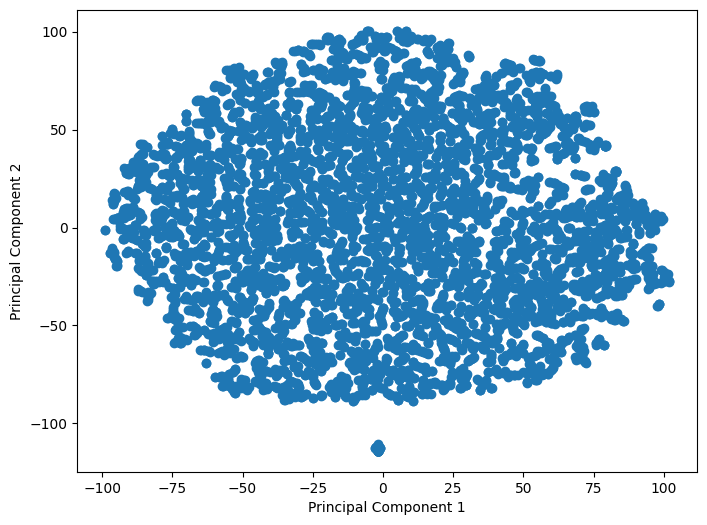

In [16]:
#tSNE and Birch and Optics for all states windowed
X_all = normalized_windowed_all_df.values
X_all_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(X_all)
X_all_embedded = pd.DataFrame(X_all_embedded)
X_all_embedded.columns = ["pc1", "pc2"]
plt.figure(figsize=(8, 6))
plt.scatter(X_all_embedded.loc[:,"pc1"], X_all_embedded.loc[:,"pc2"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

pc1        pc2  label
0 -60.195942 -34.312706      1
1 -61.180542 -20.894527      1
2   7.431001  33.519100      0
3 -36.761749   8.468958      3
4 -33.674294  40.769478      3

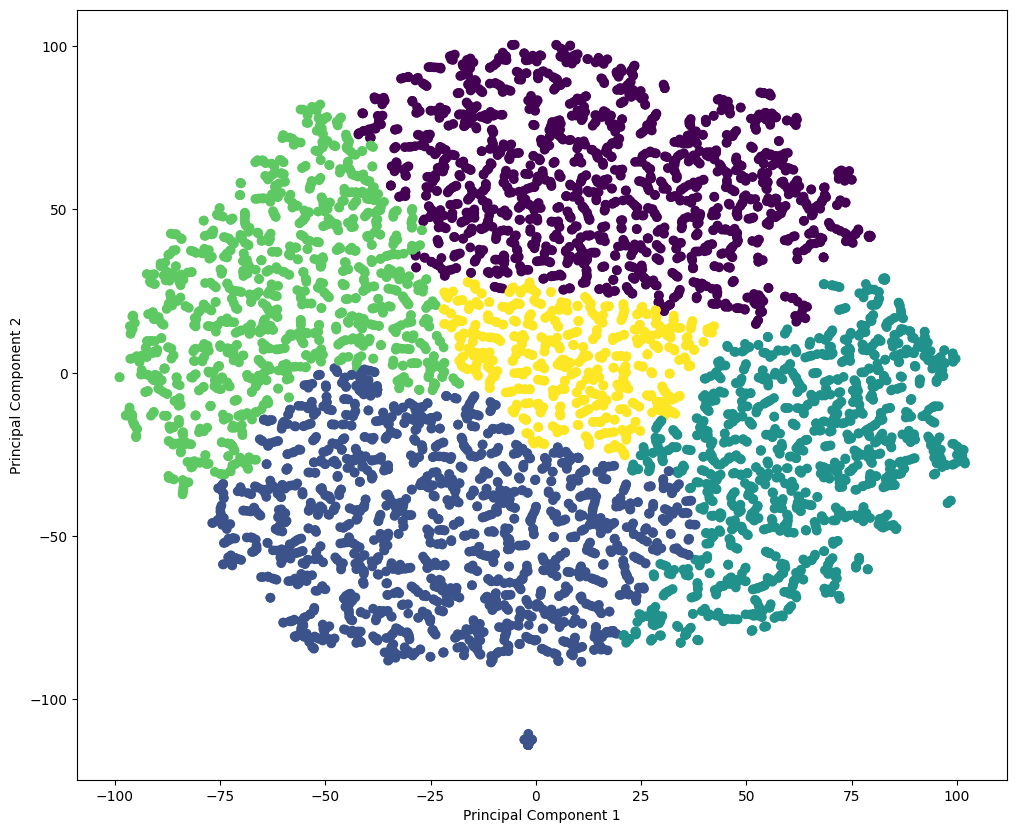

In [18]:
X_all = X_all_embedded.values
clustering = Birch(n_clusters=5).fit(X_all)
X_all_embedded["label"] = clustering.labels_
plt.figure(figsize=(12, 10))
plt.scatter(X_all_embedded["pc1"], X_all_embedded["pc2"], c=X_all_embedded["label"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
X_all_embedded.head()

/home/hmf6av/.local/lib/python3.11/site-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


pc1        pc2  label
0 -60.195942 -34.312706      0
1 -61.180542 -20.894527   2177
2   7.431001  33.519100    598
3 -36.761749   8.468958    281
4 -33.674294  40.769478    379

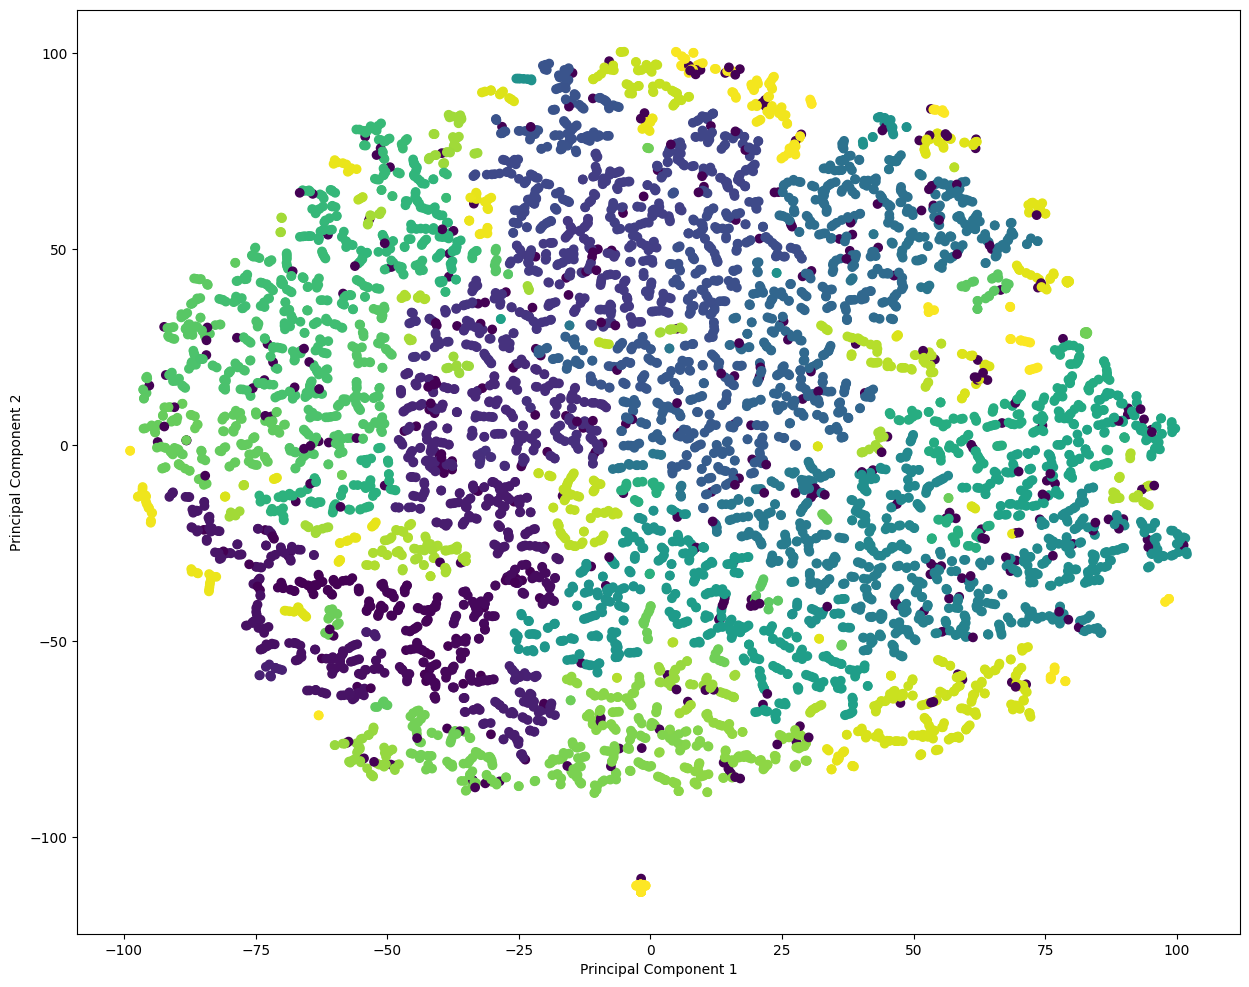

In [19]:
X_all = X_all_embedded.values
clustering = OPTICS(min_samples=2).fit(X_all)
X_all_embedded["label"] = clustering.labels_
plt.figure(figsize=(15, 12))
plt.scatter(X_all_embedded["pc1"], X_all_embedded["pc2"], c=X_all_embedded["label"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
X_all_embedded.head()

Text(0, 0.5, 'Principal Component 2')

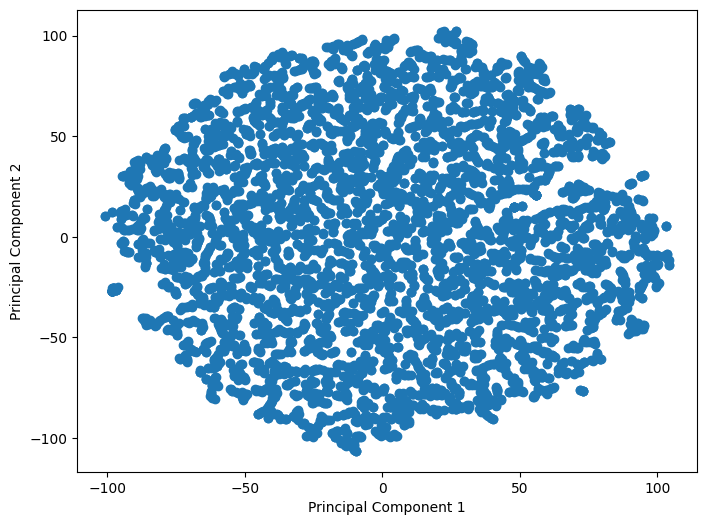

In [32]:
#tSNE Birch and Optics for MA windowed dataframe
X_ma = normalized_ma_windowed_df.values
X_ma_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(X_ma)
X_ma_embedded = pd.DataFrame(X_ma_embedded)
X_ma_embedded.columns = ["pc1", "pc2"]
plt.figure(figsize=(8, 6))
plt.scatter(X_ma_embedded.loc[:,"pc1"], X_ma_embedded.loc[:,"pc2"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

pc1        pc2  label
0 -39.222816 -88.182037      1
1 -52.592747 -65.030716      1
2 -43.229267 -48.534737      1
3 -45.042419  -9.261322      3
4 -56.498817  18.940727      3

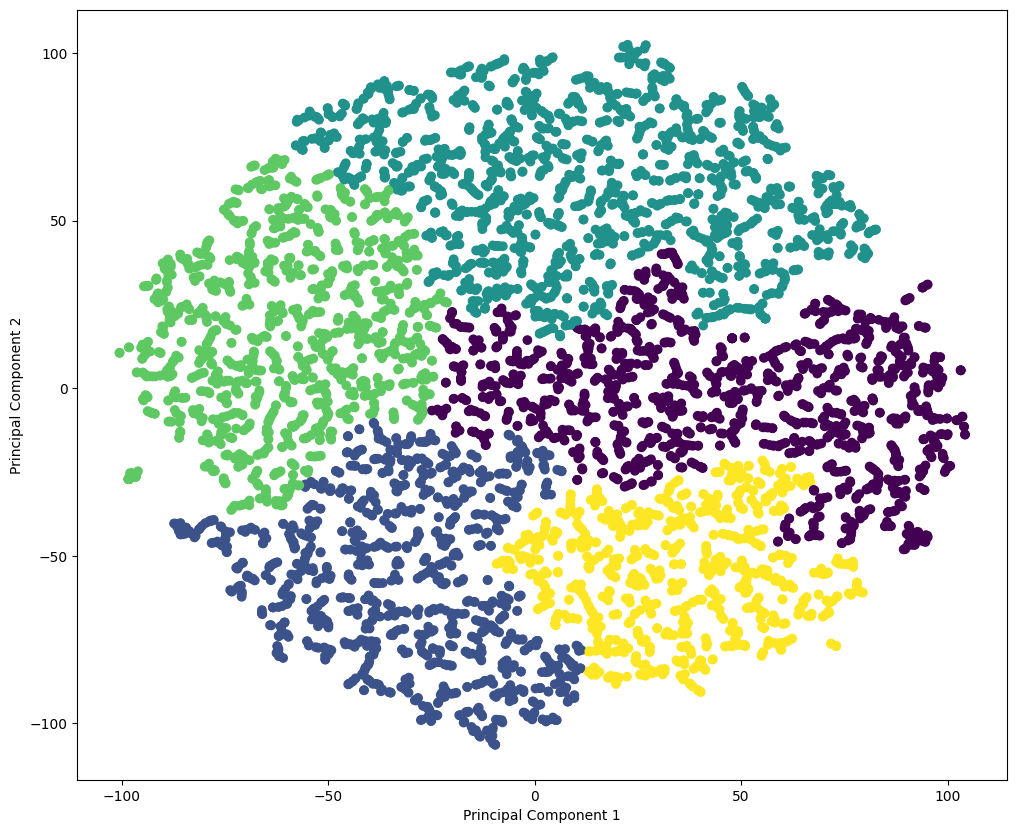

In [33]:
X_ma = X_ma_embedded.values
clustering = Birch(n_clusters=5).fit(X_ma)
X_ma_embedded["label"] = clustering.labels_
plt.figure(figsize=(12, 10))
plt.scatter(X_ma_embedded["pc1"], X_ma_embedded["pc2"], c=X_ma_embedded["label"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
X_ma_embedded.head()

/home/hmf6av/.local/lib/python3.11/site-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


pc1        pc2  label
0 -39.222816 -88.182037     -1
1 -52.592747 -65.030716    311
2 -43.229267 -48.534737     -1
3 -45.042419  -9.261322    770
4 -56.498817  18.940727    999

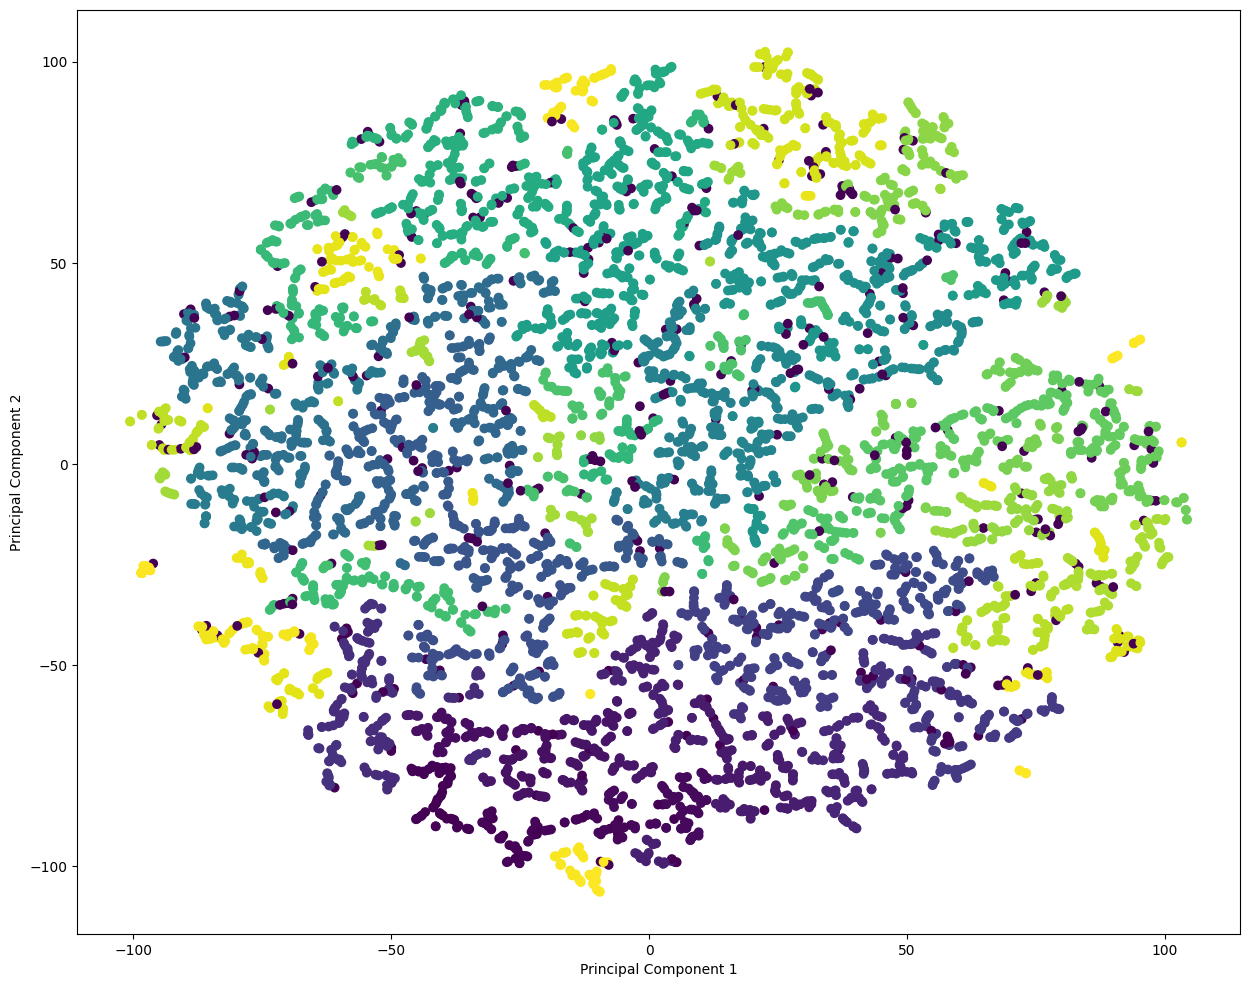

In [34]:
X_ma = X_ma_embedded.values
clustering = OPTICS(min_samples=2).fit(X_ma)
X_ma_embedded["label"] = clustering.labels_
plt.figure(figsize=(15, 12))
plt.scatter(X_ma_embedded["pc1"], X_ma_embedded["pc2"], c=X_ma_embedded["label"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
X_ma_embedded.head()

In [17]:
#Time Series Clustering for All windows
num_clusters = 6
all_model = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw",
                         max_iter=10)

In [18]:
all_model.fit(normalized_windowed_all_df)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=6)

In [19]:
all_preds = all_model.predict(normalized_windowed_all_df)

/home/hmf6av/.local/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 7367 1-dimensional timeseries
  warnings.warn(


In [20]:
all_centroids = []

for i in range(num_clusters):
    curr_series = all_model.cluster_centers_[i].ravel()
    centroid = pd.Series(data=curr_series)
    all_centroids.append(centroid)

In [21]:
all_cluster_df = pd.DataFrame({"cluster": all_preds}, index = normalized_windowed_all_df.index.values)

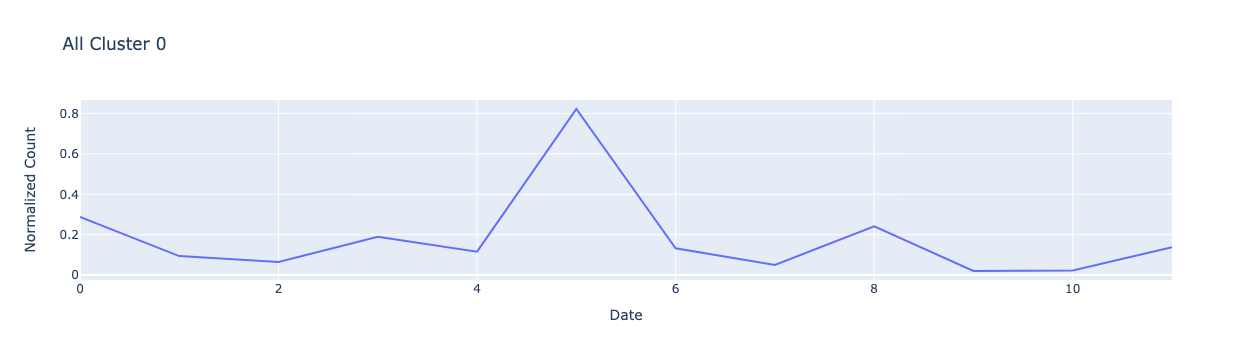

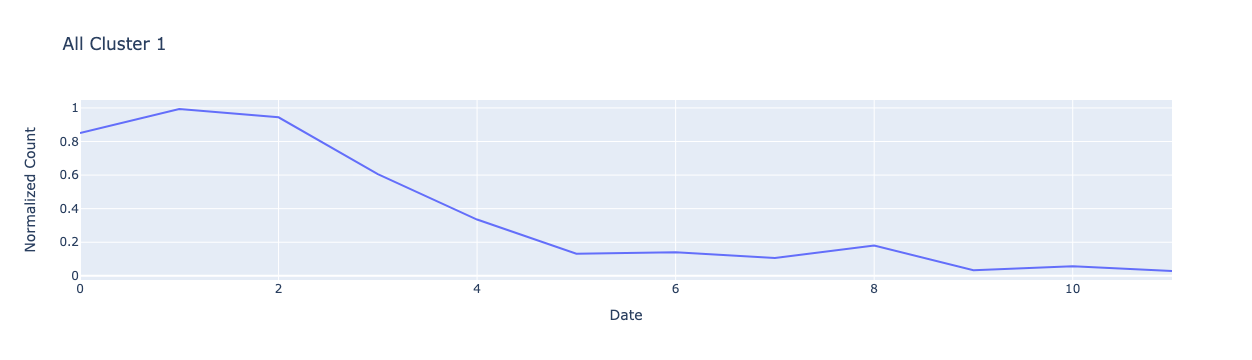

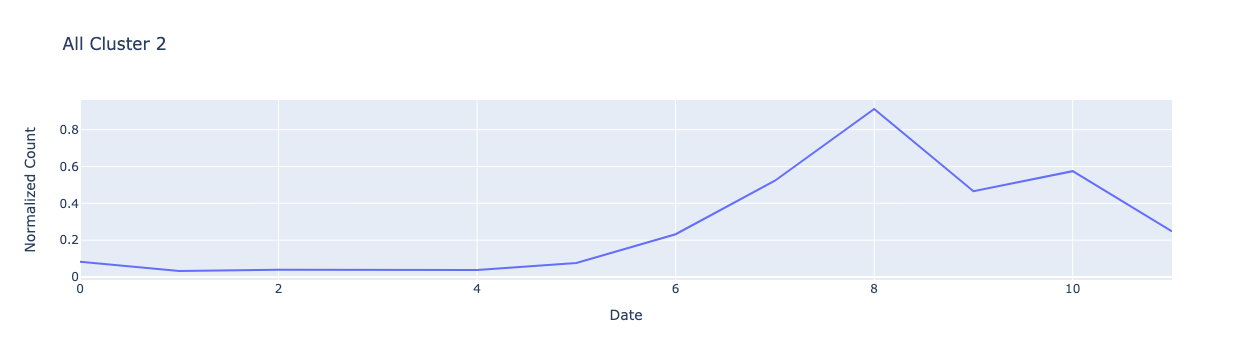

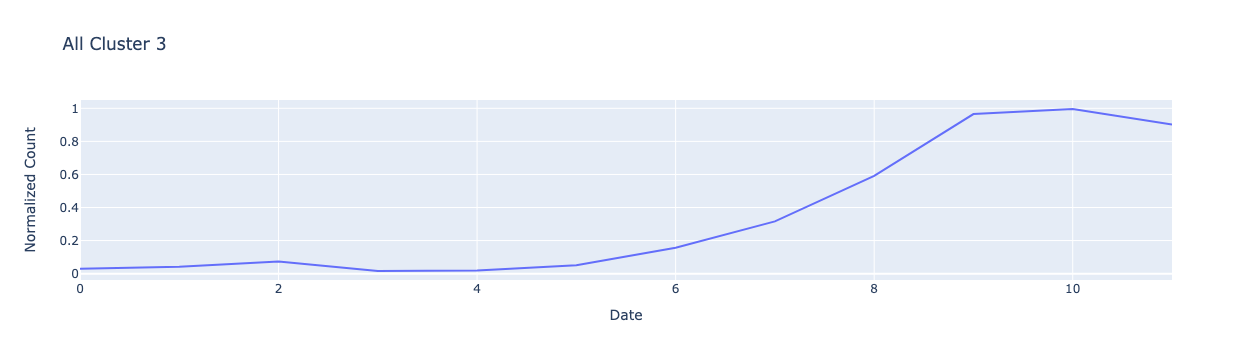

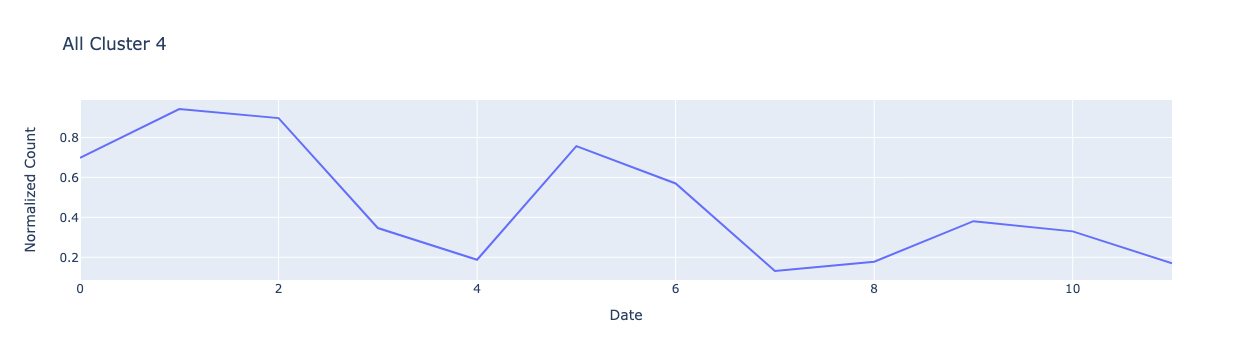

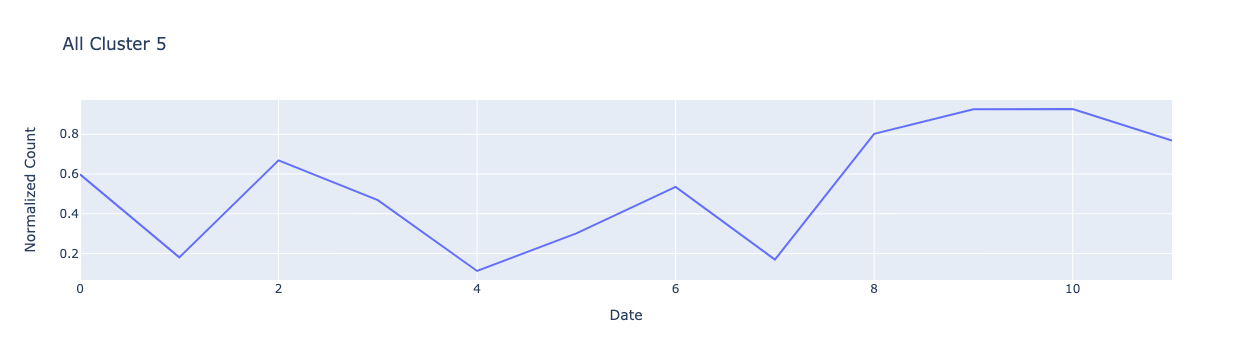

In [22]:
for i in range(num_clusters):
    fig = go.Figure()
    windows = all_cluster_df[all_cluster_df["cluster"] == i].index.values
    
    fig.add_trace(go.Scatter(y = all_centroids[i], mode = "lines", name = "Centroid"))
    """
    for window in windows:
        fig.add_trace(go.Scatter(y = df.loc[window], mode = "lines",
                                name = window))
    """
    fig.update_layout(title = f"All Cluster {i}", xaxis_title = "Date", yaxis_title = "Normalized Count", hovermode = "x")
    fig.show()

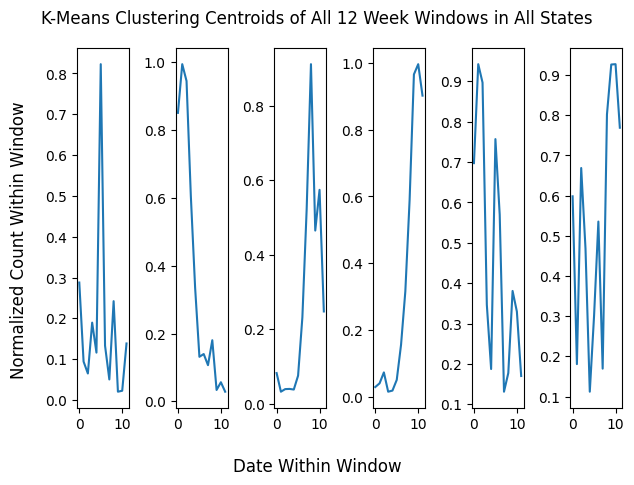

In [42]:
fig, ax = plt.subplots(1, 6)
for i in range(6):
    all_centroids[i].plot(ax = ax[i])
fig.supxlabel("Date Within Window")
fig.supylabel("Normalized Count Within Window")
fig.suptitle("K-Means Clustering Centroids of All 12 Week Windows in All States")
fig.tight_layout()
fig.savefig("kmeans_batch_distribution.png", dpi=300, bbox_inches='tight')

In [51]:
all_cluster_df["cluster"].value_counts()

1    2243
3    1785
4     985
2     962
0     835
5     557
Name: cluster, dtype: int64

In [45]:
#Time Series Clustering for MA Windows
num_clusters = 3
ma_model = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw",
                         max_iter=10)

In [46]:
ma_model.fit(normalized_ma_windowed_df)

TimeSeriesKMeans(max_iter=10, metric='dtw')

In [47]:
ma_preds = ma_model.predict(normalized_ma_windowed_df)

/home/hmf6av/.local/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning:

2-Dimensional data passed. Assuming these are 7367 1-dimensional timeseries



In [48]:
ma_centroids = []

for i in range(num_clusters):
    curr_series = ma_model.cluster_centers_[i].ravel()
    centroid = pd.Series(data=curr_series)
    ma_centroids.append(centroid)

In [49]:
ma_cluster_df = pd.DataFrame({"cluster": ma_preds}, index = normalized_ma_windowed_df.index.values)

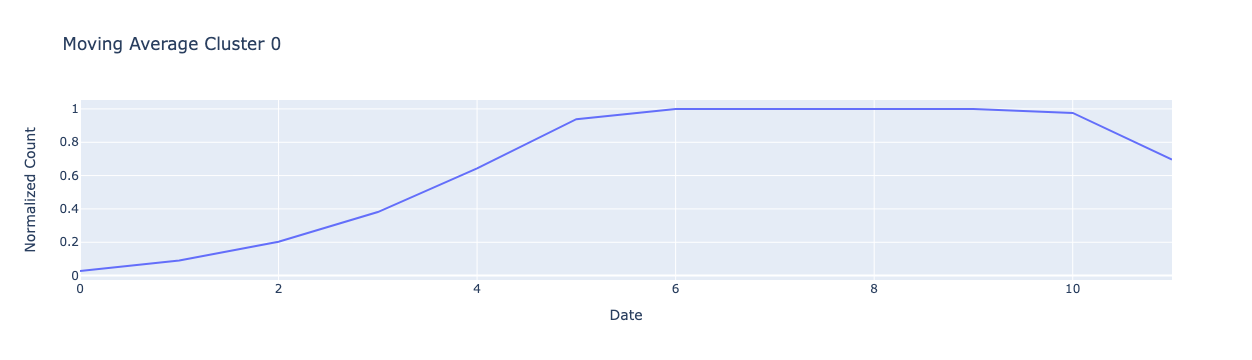

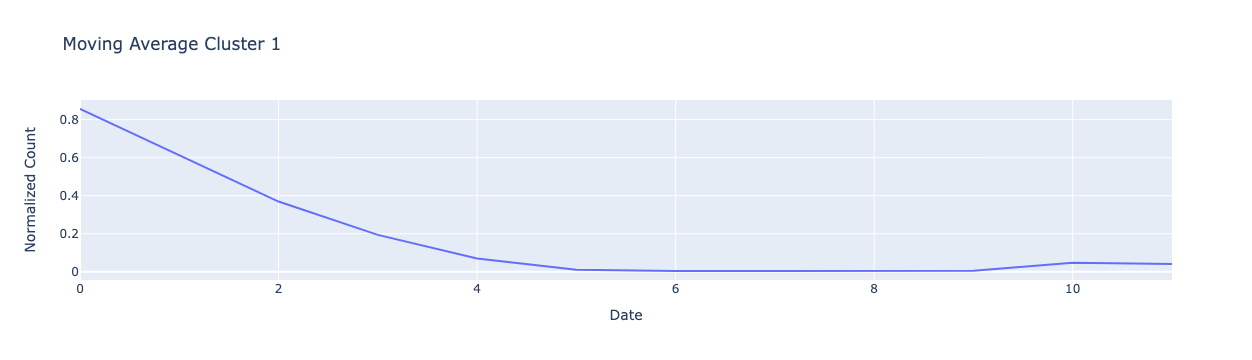

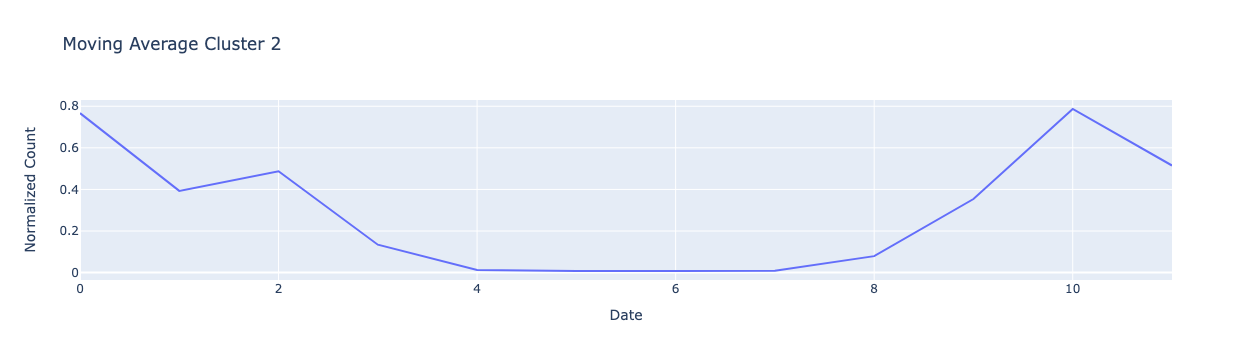

In [51]:
for i in range(num_clusters):
    fig = go.Figure()
    windows = ma_cluster_df[ma_cluster_df["cluster"] == i].index.values
    
    fig.add_trace(go.Scatter(y = ma_centroids[i], mode = "lines", name = "Centroid"))
    """
    for window in windows:
        fig.add_trace(go.Scatter(y = df.loc[window], mode = "lines",
                                name = window))
    """
    fig.update_layout(title = f"Moving Average Cluster {i}", xaxis_title = "Date", yaxis_title = "Normalized Count", hovermode = "x")
    fig.show()

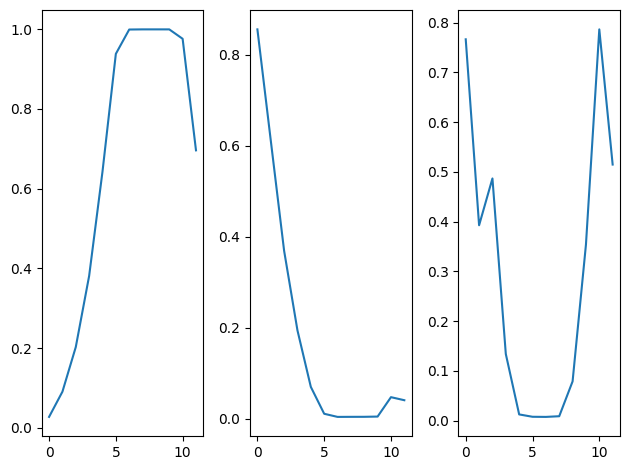

In [54]:
fig, ax = plt.subplots(1, 3)
for i in range(3):
    ma_centroids[i].plot(ax = ax[i])
plt.tight_layout()